<a href="https://colab.research.google.com/github/sled13/for_colab_nb/blob/main/Distribution_controller.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# input:
2-column distribution .csv - file with column names 'id' (string) and 'count' (non-negative float).
1. you need upload ore generate the file

In [28]:

file_name = "random_generated.csv" # @param {"type":"string","placeholder":"define analyzed filr name "}


# Generate random input.

In [80]:
seed = 1 # @param {"type":"integer","placeholder":"define seed"}
level_narrow = 50 # @param {"type":"number","placeholder":"define level for bigs"}

#you may change all parameters
#TODO: inert form filds
n_items=100
n_narrow=3
n_small=5
level_middle=15
level_small=3


id_preffix="id_"
import numpy as np
import pandas as pd

def generate_random_input():
  result={}
  np.random.seed(seed=seed)
  n_middle=n_items-n_narrow-n_small

  mu, sigma = level_small, 3*level_small # mean and standard deviation
  smalls = np.random.normal(mu, sigma, n_small)
  for ii in range(len(smalls)):
    id=f"{id_preffix}sml_{ii}"
    result[id]=max(0,smalls[ii])
  mu, sigma = level_middle, 0.8*level_middle # mean and standard deviation
  middles = np.random.normal(mu, sigma, n_middle)
  for ii in range(len(middles)):
    id=f"{id_preffix}mid_{ii}"
    result[id]=max(level_small*0.2,middles[ii])
  mu, sigma = level_narrow, 0.7*level_narrow # mean and standard deviation
  bigs = np.random.normal(mu, sigma, n_narrow)
  for ii in range(len(bigs)):
    id=f"{id_preffix}big_{ii}"
    result[id]=max(level_middle*0.3,bigs[ii])

 # for id in result:
 #   print(id,result[id])
  ids=list (result.keys())
  counts=list(result.values())
  df_res=pd.DataFrame(data={'id':ids,'count':counts})

  df_res.index.name ='record'
  print(df_res)
  df_res.to_csv("random_generated.csv")

generate_random_input()

               id      count
record                      
0        id_sml_0  17.619108
1        id_sml_1   0.000000
2        id_sml_2   0.000000
3        id_sml_3   0.000000
4        id_sml_4  10.788669
...           ...        ...
95      id_mid_90  15.928081
96      id_mid_91  10.873756
97       id_big_0  51.525890
98       id_big_1  28.299970
99       id_big_2  74.431121

[100 rows x 2 columns]


## Analysis of the file

           record       count
count  100.000000  100.000000
mean    49.500000   16.692763
std     29.011492   12.064997
min      0.000000    0.000000
3%       2.970000    0.582000
50%     49.500000   16.178092
97%     96.030000   40.233777
max     99.000000   74.431121
Index(['count', 'mean', 'std', 'min', '3%', '50%', '97%', 'max'], dtype='object')


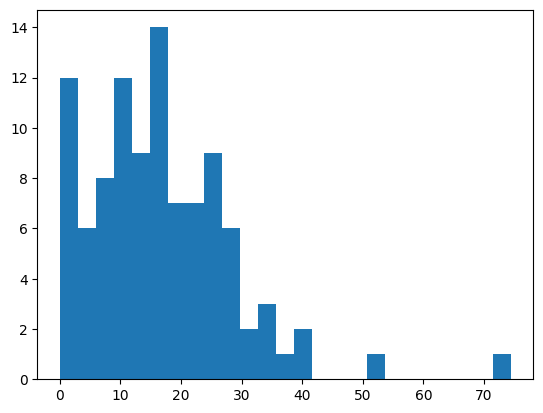

l_bound=0.582 r_bound=40.23377693496566
mid_average=15.979705778149624,mid_std=9.440813911621877,
2-sigma bound = 34.861333601393376 3-sigma bound = 44.30214751301526


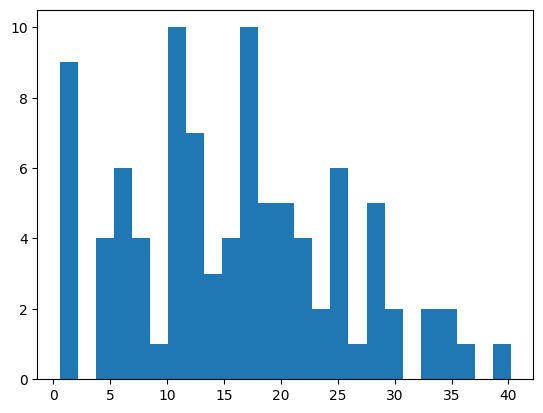

    record         id      count    level2    level3  suspect_level
6        6   id_mid_1  35.937741  0.114016  0.000000       0.057008
38      38  id_mid_33  34.917626  0.005963  0.000000       0.002981
43      43  id_mid_38  35.309455  0.047466  0.000000       0.023733
47      47  id_mid_42  40.203062  0.565812  0.000000       0.282906
68      68  id_mid_63  41.226905  0.674261  0.000000       0.337130
97      97   id_big_0  51.525890  1.765161  0.765161       1.265161
99      99   id_big_2  74.431121  4.191353  3.191353       3.691353


<Figure size 640x480 with 0 Axes>

In [85]:
percentile_level = 0.03 # @param {"type":"number","placeholder":"define percentile level to cutoff"}
weight_level2 = 0.5 # @param {"type":"number","placeholder":"define weight_level"}
sevirity = "high" # @param ["low","med","high"]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#percentile_level=0.03
sevirity_translator={"low":0, 'med':0.5,"high":1}


df_=pd.read_csv(file_name)
df_descr=df_.describe(percentiles=[percentile_level,1-percentile_level])
print(df_descr)
print(df_descr.index)

all_counters=df_['count']
plt.hist(all_counters, bins=25)
plt.show()
plt.clf()

l_bound=df_descr.loc[f'{round(100*percentile_level)}%']['count']
r_bound=df_descr.loc[f'{round(100*(1-percentile_level))}%']['count']
print(f'l_bound={l_bound} r_bound={r_bound}')

middle_counts=[count for count in all_counters if count>l_bound and count<r_bound ]
avg_=np.mean(middle_counts)
std_=np.std(middle_counts)
sigma2_bound=avg_+2*std_
sigma3_bound=avg_+3*std_
print(f'mid_average={avg_},mid_std={std_},\n2-sigma bound = {sigma2_bound} 3-sigma bound = {sigma3_bound}' )
plt.hist(middle_counts, bins=25)
plt.show()
plt.clf()

df_['level2']=(df_['count']-sigma2_bound)/std_
df_['level3']=(df_['count']-sigma3_bound)/std_
df_outlayers = df_.drop(df_[df_['level2']<=0].index)
#print(df_outlayers)
df_outlayers.loc[df_outlayers['level3']<0,'level3']=0
#print(df_outlayers)
df_outlayers['suspect_level']=weight_level2*df_outlayers['level2']+\
 (1-weight_level2)*df_outlayers['level3']
df_outlayers.loc[df_outlayers['suspect_level']>10,'suspect_level']=10
print(df_outlayers)
df_outlayers=df_outlayers.\
drop(df_outlayers[df_outlayers['suspect_level']<sevirity_translator[sevirity]].index)
df_outlayers[['id','count','suspect_level']].to_csv(f"outlayers_{sevirity}.csv", index=False)
